TODO 
- check some of the other logs
- clean up the mess
- sanity-check the results of the interpolation
 - really weird: some high/small values visible in the plots but not findable in the dfs when probing df.min
 - also not findable when plotting the individual dimensions
- how to deal with outliers?
- keep track of to-average values in a 3D array, then do std, average operations across the appropriate dimension

- get starting point, regale into the picture
- get gazepoints into the picture
- Variability of movement duration in a condition 
- Variability of movement in space, once duration is normalized -> distance travelled?
    - gaussian processes or 3rd order polynomial to interpolate
    - mean trajectory across all relevant trials 
        - variabilty change in task-irrelevant directions
- Variability of movement in spacetime, think about this
- what about coordinate systems transformation?
- when averaging, do I do this along each coordinate or each point? does it make a difference?
    - only use successful trials, right?
    - or find out where unsucessful trials stopped
- log.Success is always False?


In [14]:
# play with arrays until they do what i want

b = np.array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]]])

b.mean(axis = 0)
b.std(axis = 0)


array([[0.        , 0.47140452, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.47140452, 0.        , 0.        , 0.        ],
       [0.47140452, 0.47140452, 0.        , 0.        , 0.47140452],
       [0.47140452, 0.        , 0.        , 0.        , 0.        ]])

In [63]:
np.where(log.Success == True)
log.Success.unique()

array([False])

In [10]:
all_trajectories = np.zeros((trials['Trial'].max(), 1500, len(coi)))
all_trajectories.shape

(6, 1500, 9)

In [12]:
all_trajectories.shape

(7, 1500, 9)

In [16]:
mean_trajectory.shape
std_trajectory = all_trajectories.std(axis = 0)
std_trajectory.shape

(1500, 9)

In [17]:
#todo leave out the first guy

"""calculates the mean trajectory and std for each dimension xyz 
of hands and viewpoint after normalizing in time (ie resampling)"""


trials = log

sampling_rate = 1500    
coi = ['Viewpoint_x', 'Viewpoint_y', 'Viewpoint_z','Lefthand_x', 'Lefthand_y',
           'Lefthand_z', 'Righthand_x', 'Righthand_y', 'Righthand_z']

# mean trajectory 
all_trajectories = np.zeros((trials['Trial'].max() + 1, 1500, len(coi)))
#mean_trajectory = all_trajectories.mean(axis = 0)


for i in range(trials['Trial'].max() + 1):

    # select trial
    idx = np.where(log.Trial == i)
    trial = log.iloc[idx]

    # normalize time
    newtime = np.linspace(0, 1, num = len(trial))
    trial['time_norm'] = newtime

    interpdf_trial = pd.DataFrame()
    total = np.zeros((sampling_rate,len(coi)))

    # upsample        
    for j, column in enumerate(coi):

        # interpolate 3rd order
        cs = CubicSpline(trial.time_norm, s2f(trial[column]))

        # sample from interpolation and make column
        sample = cs(np.linspace(0, 1, sampling_rate))
        #print('max and min are: ' +  str(sample.max()) + str(sample.min()))

        interpdf_trial[column] = sample
        #print(sample, sample.shape)

        all_trajectories[i, :, j] = sample

mean_trajectory = all_trajectories.mean(axis = 0)
std_trajectory = all_trajectories.std(axis = 0)


C:\Users\gffun\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gffun\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gffun\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [26]:
mean_trajectory[:,j][10:-10].shape
std_trajectory[:,j][10:-10].shape
#x.shape

(1480,)

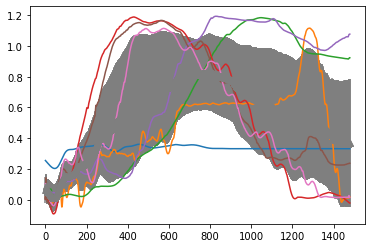

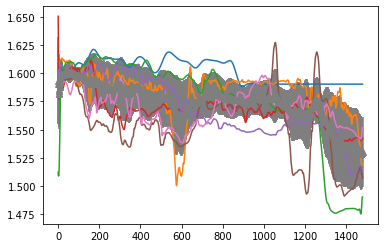

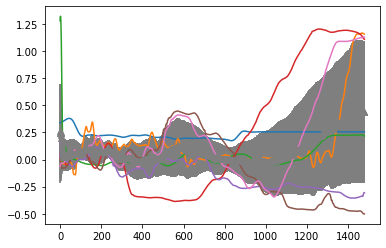

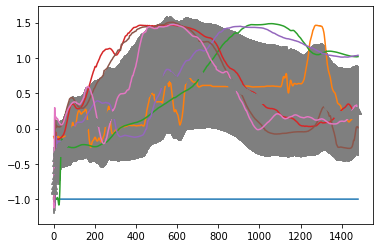

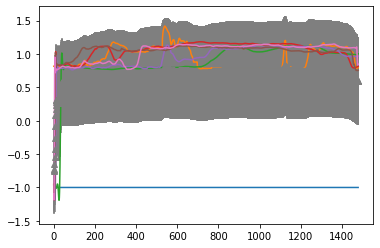

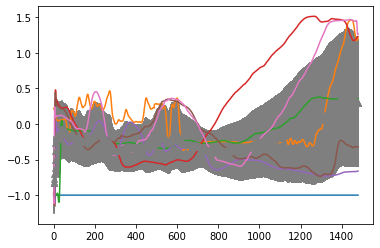

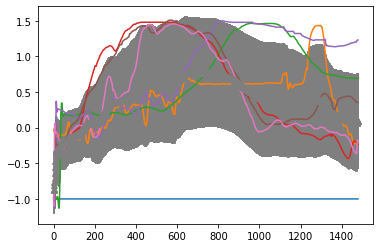

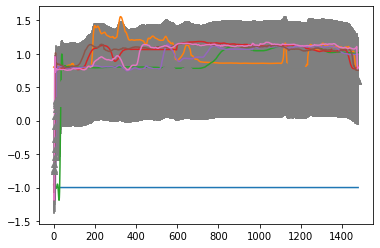

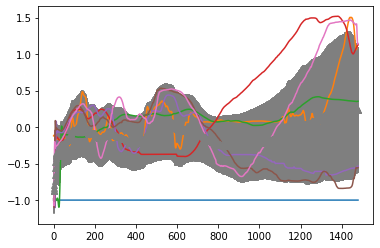

In [27]:
for j in range(all_trajectories.shape[2]):
    plt.clf
    for i in range(all_trajectories.shape[0]):
        
        plt.plot(all_trajectories[i,:,j][10:-10])
        
    #plt.plot(mean_trajectory[:,j][10:-10], color= 'red', linewidth = 4)
    x = np.arange(0, mean_trajectory[:,j][10:-10].shape[0])
    plt.errorbar(x, mean_trajectory[:,j][10:-10], std_trajectory[:,j][10:-10],
                 linestyle='None', marker='^')

    plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import CubicSpline
import time
%matplotlib inline

In [2]:
c3d = pd.read_csv('vpn1_1_c3d.csv', sep = ';') #60Hz
log = pd.read_csv('vpn1_1_log.csv', sep = ';') #24Hz
gp = pd.read_csv('vpn1_1_log_gp.csv', sep = ';') #100Hz

In [3]:
# print(log.columns)

def adjust_columns(dataframe, filetype = 'log'):
    
    """
    takes in a dataframe derived from a .csv ouput from
    WalkNGrab
    
    if input is WalknGrab log file:
    removes redundant whitespace and the like in columns
    trail -> trial
    Zeit -> time
    
    if input is WalknGrab c3d file:
    removes redundant whitespace and the like in columns
    Zeit -> time   
    Event -> event
    
    if input is WalknGrab gp file:
    removes redundant whitespace and the like in columns
    removes info_point_
    Event -> event
    """
    #print(dataframe.columns)
    
    if filetype == 'log':
        
        # Note: Cube_PX_xyz are the cornerpoints of the cube
        dataframe.columns = ['VPN', 'Block', 'Trial', 'TrialType', 'Zeitdruck',
           'TrialDuration', 'Zielregal',
           'Distance(Cube_center, Perfect_Position)', 'Viapoint passed',
           'Intersection(Cube,Placement)', 'Success', 'Event',
           'time', 'Sensorgroesse', 'Cube_x', 'Cube_y', 'Cube_z',
           'Cube_yaw', 'Cube_pitch', 'Cube_roll', 'Cube_P1_x',
           'Cube_P1_y', 'Cube_P1_z', 'Cube_P2_x', 'Cube_P2_y',
           'Cube_P2_z', 'Cube_P3_x', 'Cube_P3_y', 'Cube_P3_z',
           'Cube_P4_x', 'Cube_P4_y', 'Cube_P4_z', 'Cube_P5_x',
           'Cube_P5_y', 'Cube_P5_z', 'Cube_P6_x', 'Cube_P6_y',
           'Cube_P6_z', 'Cube_P7_x', 'Cube_P7_y', 'Cube_P7_z',
           'Cube_P8_x', 'Cube_P8_y', 'Cube_P8_z', 'Cubesize',
           'Placement_x', 'Placement_y', 'Placement_z',
           'Distance(Cube_center,Placement_center)',
           'Perfect_Position_x', 'Perfect_Position_y', 'Perfect_Position_z',
           'Viewpoint_x', 'Viewpoint_y', 'Viewpoint_z', 'Viewpoint_yaw',
           'Viewpoint_pitch', 'Viewpoint_roll', 'Lefthand_x', 'Lefthand_y',
           'Lefthand_z', 'Lefthand_yaw', 'Lefthand_pitch', 'Lefthand_roll',
           'Righthand_x', 'Righthand_y', 'Righthand_z',
           'Righthand_yaw', 'Righthand_pitch', 'Righthand_roll',
           'Head_x', 'Head_y', 'Head_z', 'Head_yaw', 'Head_pitch',
           'Head_roll']
    
    elif filetype == 'c3d':
        dataframe.columns = ['pointTracker000_x', 'pointTracker000_y', 'pointTracker000_z', 
               'pointTracker001_x', 'pointTracker001_y', 'pointTracker001_z',
               'pointTracker002_x', 'pointTracker002_y', 'pointTracker002_z',
               'pointTracker003_x', 'pointTracker003_y', 'pointTracker003_z',
               'pointTracker004_x', 'pointTracker004_y', 'pointTracker004_z',
               'pointTracker005_x', 'pointTracker005_y', 'pointTracker005_z',
               'pointTracker006_x', 'pointTracker006_y', 'pointTracker006_z',
               'pointTracker007_x', 'pointTracker007_y', 'pointTracker007_z',
               'pointTracker008_x', 'pointTracker008_y', 'pointTracker008_z',
               'pointTracker009_x', 'pointTracker009_y', 'pointTracker009_z',
               'pointTracker010_x', 'pointTracker010_y', 'pointTracker010_z',
               'pointTracker011_x', 'pointTracker011_y', 'pointTracker011_z',
               'pointTracker012_x', 'pointTracker012_y', 'pointTracker012_z',
               'pointTracker013_x', 'pointTracker013_y', 'pointTracker013_z',
               'pointTracker014_x', 'pointTracker014_y', 'pointTracker014_z',
               'pointTracker015_x', 'pointTracker015_y', 'pointTracker015_z',
               'pointTracker016_x', 'pointTracker016_y', 'pointTracker016_z',
               'pointTracker017_x', 'pointTracker017_y', 'pointTracker017_z',
               'pointTracker018_x', 'pointTracker018_y', 'pointTracker018_z',
               'pointTracker019_x', 'pointTracker019_y', 'pointTracker019_z',
               'pointTracker020_x', 'pointTracker020_y', 'pointTracker020_z',
               'pointTracker021_x', 'pointTracker021_y', 'pointTracker021_z',
               'pointTracker022_x', 'pointTracker022_y', 'pointTracker022_z',
               'pointTracker023_x', 'pointTracker023_y', 'pointTracker023_z',
               'pointTracker024_x', 'pointTracker024_y', 'pointTracker024_z',
               'pointTracker025_x', 'pointTracker025_y', 'pointTracker025_z',
               'pointTracker026_x', 'pointTracker026_y', 'pointTracker026_z',
               'pointTracker027_x', 'pointTracker027_y', 'pointTracker027_z',
               'pointTracker028_x', 'pointTracker028_y', 'pointTracker028_z',
               'pointTracker029_x', 'pointTracker029_y', 'pointTracker029_z',
               'pointTracker030_x', 'pointTracker030_y', 'pointTracker030_z',
               'pointTracker031_x', 'pointTracker031_y', 'pointTracker031_z',
               'pointTracker032_x', 'pointTracker032_y', 'pointTracker032_z',
               'pointTracker033_x', 'pointTracker033_y', 'pointTracker033_z',
               'pointTracker034_x', 'pointTracker034_y', 'pointTracker034_z', 
               'pointTracker035_x', 'pointTracker035_y', 'pointTracker035_z',
               'pointTracker036_x', 'pointTracker036_y', 'pointTracker036_z',
               'pointTracker037_x', 'pointTracker037_y', 'pointTracker037_z',
               'event', 'time']
    
    elif filetype == 'gp':
        dataframe.columns = ['time','x','y','z']
    

    #print(dataframe.columns)
    
    return dataframe

In [4]:
# testing adjust_columns
#print(adjust_columns(log, filetype = 'log'))
#print(adjust_columns(gp, filetype = 'gp'))
#print(adjust_columns(c3d, filetype = 'c3d'))
log = adjust_columns(log)

In [23]:
log = pd.read_csv('vpn1_5_log.csv', sep = ';') #24Hz
log = adjust_columns(log)

log['Success'].value_counts()

False    6091
True       22
Name: Success, dtype: int64

In [5]:
def s2f(string):
    
    """
    checks if string is either a string or an array of strings
    returns a float, if the string was 23,2435 - like
    """
    
    if type(string) == np.ndarray:
    
        string = np.char.replace(string.astype('<U8'), ',','.')
        return string.astype(np.float)
    
    elif type(string) == pd.core.series.Series:
        string = np.char.replace(string.to_numpy().astype('<U8'), ',','.')
        return string.astype(np.float)
    
    elif type(string) == str:
        string = string.replace(',','.')
        return float(string)
    
    else:
        return "input is neither string nor array of strings"
        

In [6]:
def get_variability_duration(trials, adjust_columns = True):
    """calculates variability of a movement duration
    trials: pd.DataFrame of stacked trials"""
    
    # adjust columns 
    #if adjust_columns:
    #    trials = adjust_columns(trials)
    
    # get durations of trials
    durations = s2f(trials.TrialDuration)
    idx = np.where(durations!= 0.0)
    durations = durations[idx]

    # calculate statistics
    mean = durations.mean()
    sigma = durations.std()
    
    return mean, sigma

In [57]:
def get_variability_space(trials, adjust_columns = True, sampling_rate = 1500):
    """calculates variability of a movement in space, 
    once duration is normalized"""
    
    # avoid warning
    pd.set_option('mode.chained_assignment', None)

    # adjust columns 
    #if adjust_columns:
    #    trials = adjust_columns(trials)
    
    # define columns of interest
    coi = ['Viewpoint_x', 'Viewpoint_y', 'Viewpoint_z','Lefthand_x', 'Lefthand_y',
           'Lefthand_z', 'Righthand_x', 'Righthand_y', 'Righthand_z']
    
    #define interpolated df
    interpdf = pd.DataFrame(columns = coi)
    #interpdf.columns = coi
    
    for i in range(trials['Trial'].max() + 1):
        
        # select trial
        idx = np.where(log.Trial == i)
        trial = log.iloc[idx]
    
        # normalize time
        newtime = np.linspace(0, 1, num = len(trial))
        trial['time_norm'] = newtime
    
        interpdf_trial = pd.DataFrame()
        total = np.zeros((sampling_rate,len(coi)))
        
        # upsample        
        for column in coi:
 #       interpdf[column] = np.interp(np.linspace(0,1, upsampling_N), trial.time, s2f(coi[column]))    
            # this should ideally be a 3rd order polymer
           
            # interpolate
            cs = CubicSpline(trial.time_norm, s2f(trial[column]))

            # sample from interpolation and make column
            sample = cs(np.linspace(0, 1, sampling_rate))
            print('max and min are: ' +  str(sample.max()) + str(sample.min()))
            
            interpdf_trial[column] = sample
            
            #interpdf_trial['Trial'] = np.full((len(interpdf_trial),), i)
            
            #interpdf_trial[column] = np.interp(np.linspace(0,1, sampling_rate), trial.time_norm, s2f(trial[column])) 
        
        
        
        # plotting for sanity
#         fig = plt.figure(figsize=plt.figaspect(1/2.))
    
#         ax = fig.add_subplot(1, 2, 1, projection='3d')
#         ax.plot3D(s2f(trial.Lefthand_x), s2f(trial.Lefthand_z), s2f(trial.Lefthand_y), 'blue')
#         ax.plot3D(s2f(trial.Righthand_x), s2f(trial.Righthand_z), s2f(trial.Righthand_y), 'green')
#         ax.plot3D(s2f(trial.Viewpoint_x), s2f(trial.Viewpoint_z), s2f(trial.Viewpoint_y), 'gray')
    
#         ax = fig.add_subplot(1, 2, 2)
#         ax.plot(s2f(trial.Lefthand_x), s2f(trial.Lefthand_z), 'blue')
#         ax.plot(s2f(trial.Righthand_x), s2f(trial.Righthand_z), 'green')
#         ax.plot(s2f(trial.Viewpoint_x), s2f(trial.Viewpoint_z), 'gray')
        
        
        fig = plt.figure(figsize=plt.figaspect(1/2.))
    
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.plot3D(s2f(interpdf_trial.Lefthand_x), s2f(interpdf_trial.Lefthand_z), s2f(interpdf_trial.Lefthand_y), 'blue')
        ax.plot3D(s2f(interpdf_trial.Righthand_x), s2f(interpdf_trial.Righthand_z), s2f(interpdf_trial.Righthand_y), 'green')
        ax.plot3D(s2f(interpdf_trial.Viewpoint_x), s2f(interpdf_trial.Viewpoint_z), s2f(interpdf_trial.Viewpoint_y), 'gray')
    
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(s2f(interpdf_trial.Lefthand_x), s2f(interpdf_trial.Lefthand_z), 'blue')
        ax.plot(s2f(interpdf_trial.Righthand_x), s2f(interpdf_trial.Righthand_z), 'green')
        ax.plot(s2f(interpdf_trial.Viewpoint_x), s2f(interpdf_trial.Viewpoint_z), 'gray')
  
         #with cutting
#         ax = fig.add_subplot(1, 2, 1, projection='3d')
#         ax.plot3D(s2f(interpdf_trial.Lefthand_x[100:-100]), s2f(interpdf_trial.Lefthand_z[100:-100]), s2f(interpdf_trial.Lefthand_y[100:-100]), 'blue')
#         ax.plot3D(s2f(interpdf_trial.Righthand_x[100:-100]), s2f(interpdf_trial.Righthand_z[100:-100]), s2f(interpdf_trial.Righthand_y[100:-100]), 'green')
#         ax.plot3D(s2f(interpdf_trial.Viewpoint_x[100:-100]), s2f(interpdf_trial.Viewpoint_z[100:-100]), s2f(interpdf_trial.Viewpoint_y[100:-100]), 'gray')
    
#         ax = fig.add_subplot(1, 2, 2)
#         ax.plot(s2f(interpdf_trial.Lefthand_x[100:-100]), s2f(interpdf_trial.Lefthand_z[100:-100]), 'blue')
#         ax.plot(s2f(interpdf_trial.Righthand_x[100:-100]), s2f(interpdf_trial.Righthand_z[100:-100]), 'green')
#         ax.plot(s2f(interpdf_trial.Viewpoint_x[100:-100]), s2f(interpdf_trial.Viewpoint_z[100:-100]), 'gray')
  
    
    
        #print(interpdf_trial.min())
        
        # add trial to total
        total += interpdf_trial
        
        # append trial indication 
        interpdf_trial['Trial'] = np.full((len(interpdf_trial),), i)

        interpdf = interpdf.append(interpdf_trial)
    
    # get average across trials
    average = total/trials['Trial'].max()
    average.columns = coi
    
    #trial6 = interpdf.iloc[np.where(interpdf['Trial'] == 6.0)]

    
    # calculate sigma
    #sigma = 0
    #return sigma
    return interpdf, average
    

In [50]:
dff = pd.DataFrame()
dff['0s'] = np.zeros((1500,))
dff['1s'] = np.ones((1500,))
#np.ones((1500,))+np.ones((1500,))+np.zeros((1500,))
dff['0s'] + dff['1s'] + dff['1s']
dff + dff + dff
trial6 = interpdf.iloc[np.where(interpdf['Trial'] == 6.0)]
trial5 = interpdf.iloc[np.where(interpdf['Trial'] == 5.0)]
dfff = trial5 + trial6 + trial5 + trial6
dfff/5

,Viewpoint_x,Viewpoint_y,Viewpoint_z,Lefthand_x,Lefthand_y,Lefthand_z,Righthand_x,Righthand_y,Righthand_z,Trial
0,0.541432,1.202990,-0.313608,-0.800000,-0.800000,-0.800000,-0.800000,-0.800000,-0.800000,4.4
1,0.483025,1.211650,-0.276587,-0.802215,-0.803583,-0.802427,-0.801742,-0.803578,-0.801701,4.4
2,0.501045,1.207575,-0.294353,-0.801220,-0.802022,-0.801396,-0.800946,-0.802017,-0.801003,4.4
3,0.552235,1.199240,-0.330197,-0.799113,-0.798642,-0.799121,-0.799283,-0.798640,-0.799422,4.4
4,0.593338,1.195124,-0.347409,-0.797998,-0.796770,-0.797815,-0.798424,-0.796774,-0.798473,4.4
...,...,...,...,...,...,...,...,...,...,...
1495,0.107947,1.217989,0.262689,-0.077190,0.477635,0.169552,-0.009514,0.458719,0.008571,4.4
1496,0.109125,1.219424,0.267978,-0.304129,0.133917,-0.255973,-0.156300,0.121184,-0.394279,4.4
1497,0.108137,1.222674,0.220702,-0.507114,-0.183168,-0.648107,-0.291811,-0.190065,-0.760939,4.4
1498,0.103584,1.228679,0.078178,-0.579657,-0.311717,-0.806416,-0.346948,-0.316166,-0.901179,4.4


505

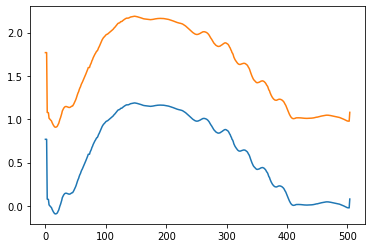

In [28]:
vpx = s2f(log.iloc[np.where(log.Trial == 3)].Viewpoint_x)
x = np.arange(0, len(vpx))
cs = CubicSpline(x, vpx)
xs = np.arange(0, len(vpx))

plt.plot(vpx)
plt.plot(cs(xs)+1)
len(vpx)

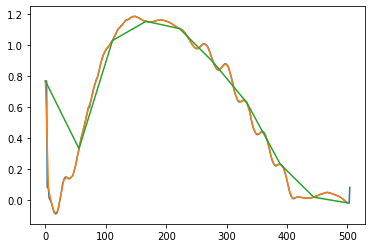

In [46]:
plt.plot(xs, cs(xs))
plt.plot(np.linspace(0, 500, 100), cs(np.linspace(0, 500, 100)))
plt.plot(np.linspace(0, 500, 10), cs(np.linspace(0, 500, 10)))

In [41]:
np.linspace(0, 500, 10)

array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
       222.22222222, 277.77777778, 333.33333333, 388.88888889,
       444.44444444, 500.        ])

max and min are: 0.36073698927228940.20335671668730634
max and min are: 1.62107473805097311.5883023928015723
max and min are: 0.37964130843332070.17400176992052777
max and min are: -1.0-1.0
max and min are: -1.0-1.0
max and min are: -1.0-1.0
max and min are: -1.0-1.0
max and min are: -1.0-1.0
max and min are: -1.0-1.0
max and min are: 1.1157048665697389-0.047257289837380624
max and min are: 1.61346807933273561.500561325763731
max and min are: 1.1704930000000002-0.14075141370840263
max and min are: 1.4626121444457403-1.0770542119357416
max and min are: 1.4177938329350646-1.1520212168347677
max and min are: 1.4633607635717443-1.1004060478849118
max and min are: 1.4341711019085768-1.0845852799422295
max and min are: 1.5538597097432514-1.1501205972838942
max and min are: 1.5032400455403534-1.0720198973816009
max and min are: 1.18363391065561880.010373430790115089
max and min are: 1.61642040439138081.231823
max and min are: 1.3213906738823347-0.05715874848380857
max and min are: 1.485193637

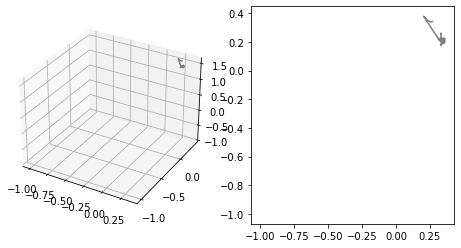

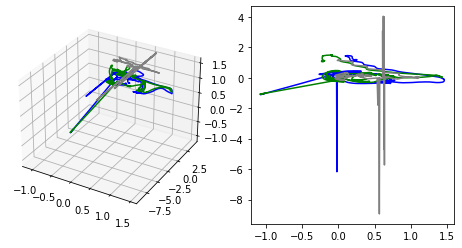

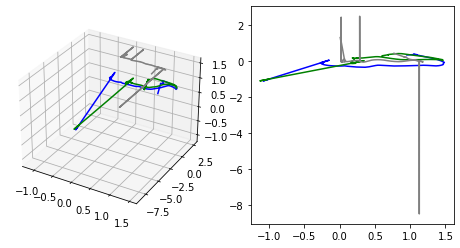

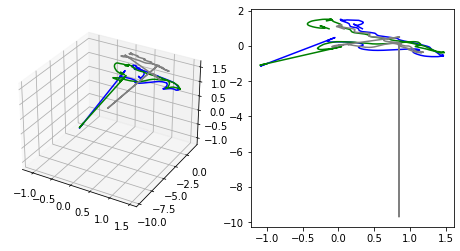

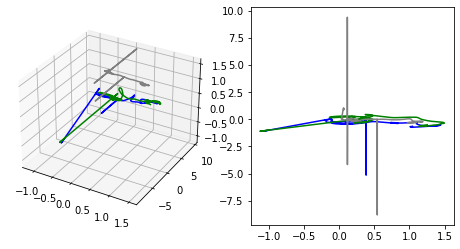

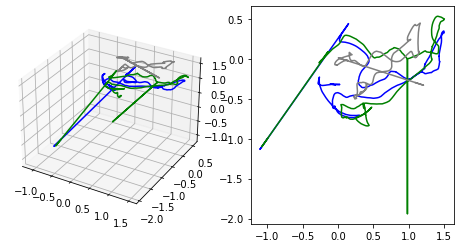

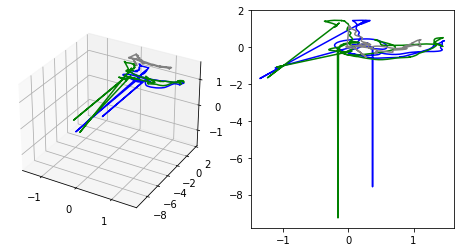

In [58]:
#print(get_variability_space(log))
interpdf, average = get_variability_space(log)

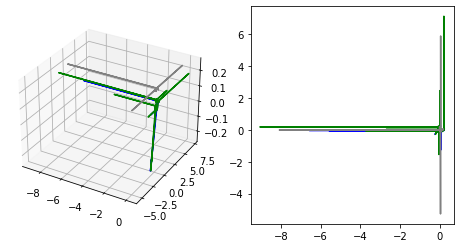

In [59]:
fig = plt.figure(figsize=plt.figaspect(1/2.))
    
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(s2f(average.Lefthand_x), s2f(average.Lefthand_z), s2f(average.Lefthand_y), 'blue')
ax.plot3D(s2f(average.Righthand_x), s2f(average.Righthand_z), s2f(average.Righthand_y), 'green')
ax.plot3D(s2f(average.Viewpoint_x), s2f(average.Viewpoint_z), s2f(average.Viewpoint_y), 'gray')
    
ax = fig.add_subplot(1, 2, 2)
ax.plot(s2f(average.Lefthand_x), s2f(average.Lefthand_z), 'blue')
ax.plot(s2f(average.Righthand_x), s2f(average.Righthand_z), 'green')
ax.plot(s2f(average.Viewpoint_x), s2f(average.Viewpoint_z), 'gray')
  

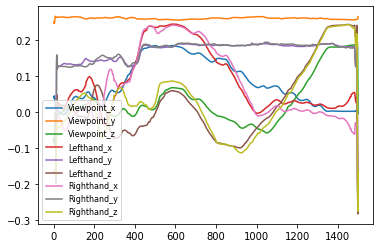

In [67]:
for column in average.columns:
    plt.plot(average[column])

plt.legend(average.columns, loc = 'lower left', fontsize = 8)

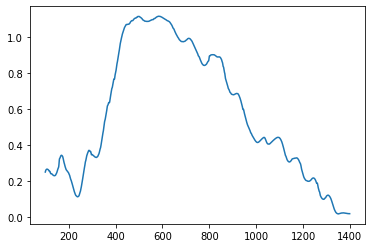

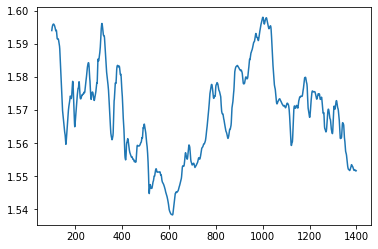

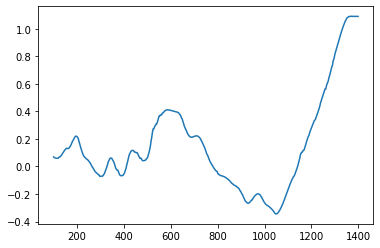

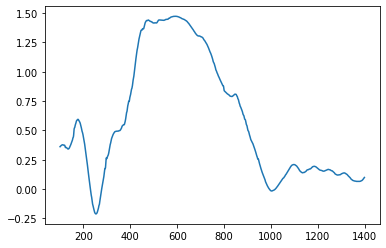

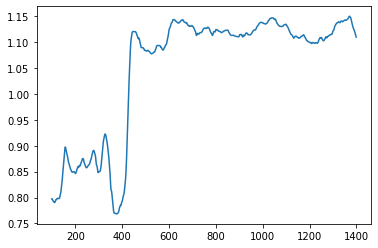

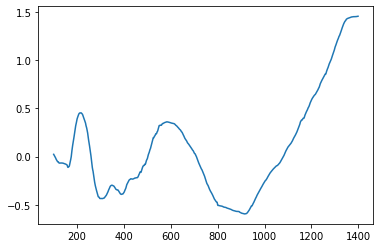

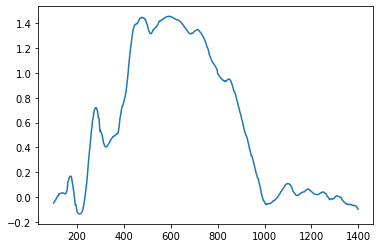

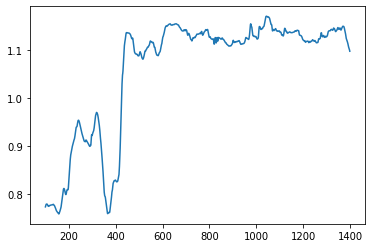

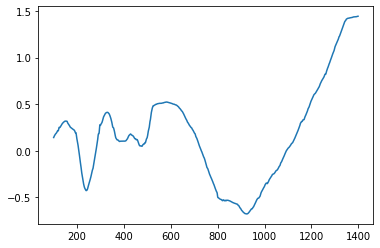

In [31]:
trial6 = interpdf.iloc[np.where(interpdf['Trial'] == 6.0)]
#interpdf.columns
for i in range(len(trial6.columns)-1):
    plt.plot(trial6.iloc[100:-100,i])
    plt.show()
    time.sleep(2)
    

In [53]:
interpdf.min()

Viewpoint_x   -0.091978
Viewpoint_y    1.044277
Viewpoint_z   -0.539139
Lefthand_x    -1.359417
Lefthand_y    -1.564170
Lefthand_z    -1.697988
Righthand_x   -1.242687
Righthand_y   -1.551821
Righthand_z   -1.657711
dtype: float64

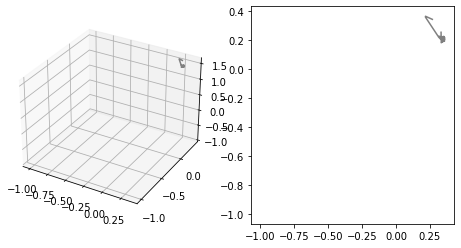

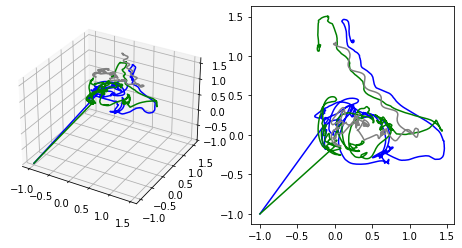

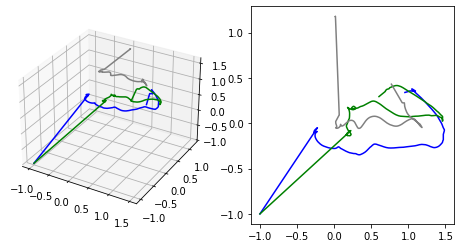

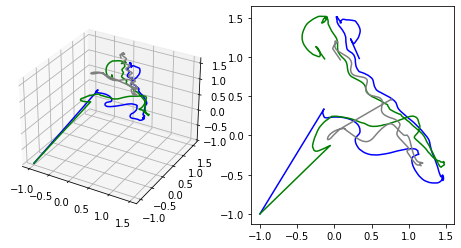

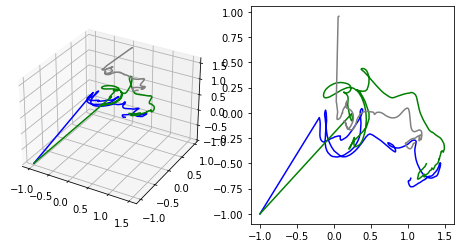

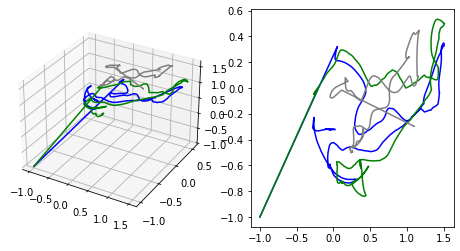

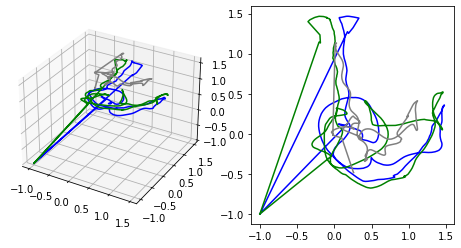

In [36]:
for i in range(7):

    idx = np.where(log.Trial == i)
    trial = log.iloc[idx]
    
    fig = plt.figure(figsize=plt.figaspect(1/2.))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot3D(s2f(trial.Lefthand_x), s2f(trial.Lefthand_z), s2f(trial.Lefthand_y), 'blue')
    ax.plot3D(s2f(trial.Righthand_x), s2f(trial.Righthand_z), s2f(trial.Righthand_y), 'green')
    ax.plot3D(s2f(trial.Viewpoint_x), s2f(trial.Viewpoint_z), s2f(trial.Viewpoint_y), 'gray')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(s2f(trial.Lefthand_x), s2f(trial.Lefthand_z), 'blue')
    ax.plot(s2f(trial.Righthand_x), s2f(trial.Righthand_z), 'green')
    ax.plot(s2f(trial.Viewpoint_x), s2f(trial.Viewpoint_z), 'gray')

In [61]:
interpdf['Viewpoint_z'][10499-4499 : 10499-2999].min()

-0.3560816477651768

In [23]:
log['Trial'].max()
[i for i in range(7)]

[0, 1, 2, 3, 4, 5, 6]

In [55]:
print(get_variability_duration(log))

(33.5365, 22.035060696913604)


In [18]:
# normalize trials in time
# for each trial, each measurement gets a new timestamp between 0 and 1
#for i in range(400, 500):
#    print(log.Zeit[i]-log.Zeit[i-1])
pd.set_option('mode.chained_assignment', None)
interpdf = pd.DataFrame()

for i in range(7):
    
    idx = np.where(log.Trial == i)
    trial = log.iloc[idx]
    
    #normalize time
    newtime = np.linspace(0, 1, num = len(trial))
    trial['time_norm'] = newtime    
    
    # upsample
    coi = trial[['Viewpoint_x', 'Viewpoint_y', 'Viewpoint_z','Lefthand_x', 'Lefthand_y',
           'Lefthand_z', 'Righthand_x', 'Righthand_y', 'Righthand_z',]]
    #print(coi)
    print(len(coi))
    
    upsampling_N = 1500
    
    for column in coi.columns:
 #       interpdf[column] = np.interp(np.linspace(0,1, upsampling_N), trial.time, s2f(coi[column]))    
       interpdf[column] = np.interp(np.linspace(0,1, upsampling_N), trial.time_norm, s2f(coi[column]))    
    
    
    newtime = np.linspace(0, 1, num = len(trial))
    trial['time_norm'] = newtime
    
    #print(newtime)
    print(len(interpdf))

    #trial = trial.assign(time_norm = newtime)

    #print(type(trial))
    #print(trial)
    
    
    
    # calculate distance travelled?!
    #distance = 

43
1500
1647
1500
196
1500
505
1500
426
1500
520
1500
638
1500


1276

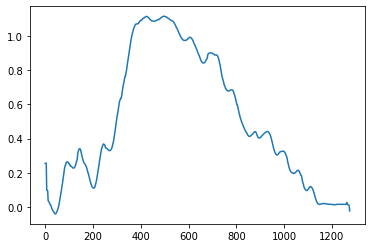

In [19]:

interp = np.interp(np.linspace(0,1, len(trial)*2), trial.time_norm, s2f(coi.Viewpoint_x))
plt.plot(interp)
#plt.plot(np.linspace(0,1, len(trial)*2), np.interp(np.linspace(0,1, len(trial)*2), s2f(coi.Viewpoint_x), trial.time_norm))
len(interp)

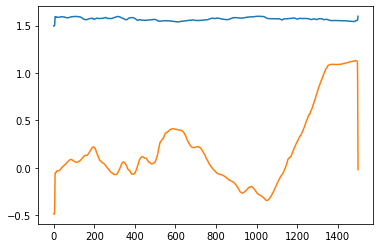

In [57]:
plt.plot(interpdf.iloc[:,1])
plt.plot(interpdf.iloc[:,2])

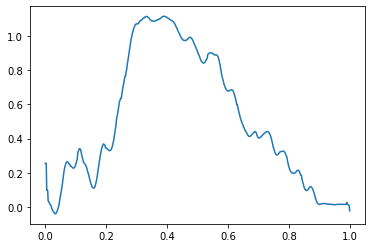

In [27]:
plt.plot(trial.time_norm,s2f(coi.Viewpoint_x))

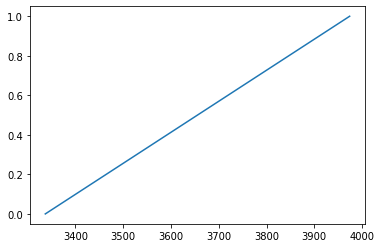

In [38]:
plt.plot( trial.time_norm)

In [49]:
for i in range(400, 500):
    print(c3d[' Zeit'][i]- c3d[' Zeit'][i-1])

0.019999980926513672
0.009999990463256836
0.019999980926513672
0.009999990463256836
0.029999971389770508
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.03000020980834961
0.009999990463256836
0.019999980926513672
0.019999980926513672
0.009999990463256836
0.029999971389770508
0.009999990463256836
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.009999990463256836
0.020000219345092773
0.019999980926513672
0.009999990463256836
0.029999971389770508
0.009999990463256836
0.019999980926513672
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.03000020980834961
0.009999990463256836
0.019999980926513672
0.009999990463256836
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.019999980926513672
0.0099999904632

In [10]:
log['Zeit']

0       1.615884e+09
1       1.615884e+09
2       1.615884e+09
3       1.615884e+09
4       1.615884e+09
            ...     
3970    1.615884e+09
3971    1.615884e+09
3972    1.615884e+09
3973    1.615884e+09
3974    1.615884e+09
Name: Zeit, Length: 3975, dtype: float64

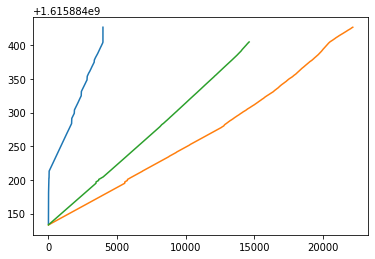

In [51]:
plt.plot(log['Zeit'])
plt.plot(gp['time'])
plt.plot(c3d[' Zeit'])

In [29]:
c3d[' Zeit'][0]
type(c3d[' Zeit'][100])


numpy.float64

In [18]:
trial1_i = np.where(log.Trial == 1)
trial1 = log.iloc[trial1_i]

In [20]:
trial1 = log.iloc[trial1_i]

In [28]:
float(trial1.Viewpoint_x[111])

ValueError: could not convert string to float: '-0,006499'

In [10]:
def s2f(string):
    string = string.replace(',','.')
    return float(string)

In [113]:
print(s2f(trial1.Viewpoint_x))

[0.331039 0.330726 0.330499 ... 0.016217 0.015813 0.01047 ]


In [110]:
type(trial1.Viewpoint_y)


pandas.core.series.Series

In [86]:
len(trial1.Viewpoint_x.to_numpy())//2#/2)

823

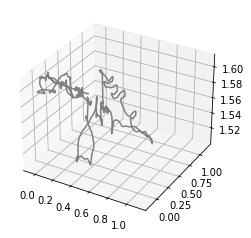

In [117]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(s2f(trial1.Viewpoint_x), s2f(trial1.Viewpoint_z), s2f(trial1.Viewpoint_y), 'gray')
#ax.scatter3D(gp.x, gp.y, gp.z, c=gp.z, cmap='Greens')


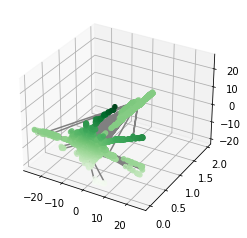

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(gp.x, gp.y, gp.z, 'gray')
ax.scatter3D(gp.x, gp.y, gp.z, c=gp.z, cmap='Greens')


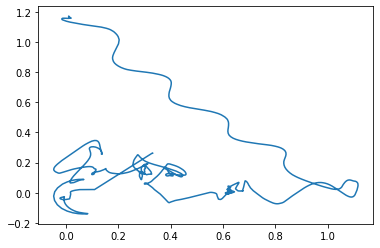

In [118]:
plt.plot(s2f(trial1.Viewpoint_x), s2f(trial1.Viewpoint_z))

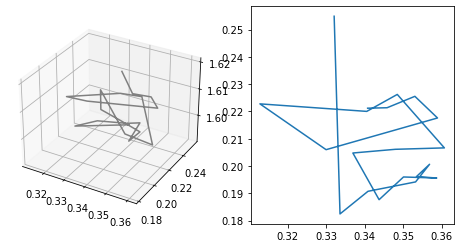

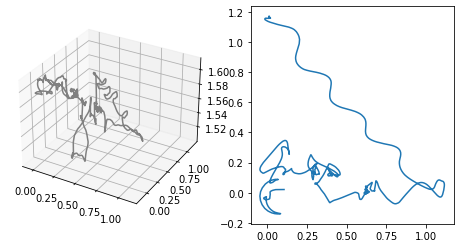

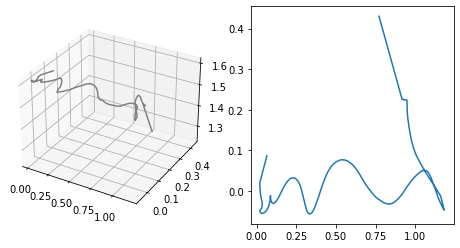

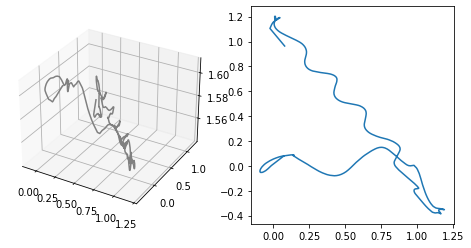

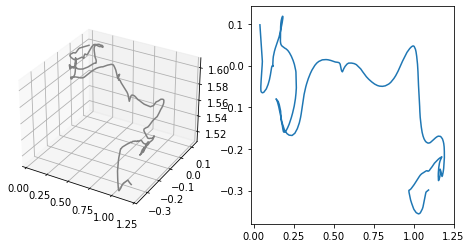

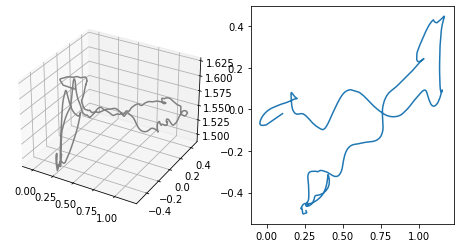

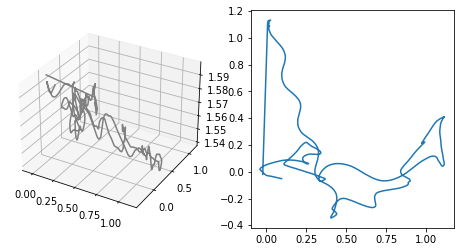

In [10]:
for i in range(7):
    
    idx = np.where(log.Trial == i)
    trial = log.iloc[idx]
    
    fig = plt.figure(figsize=plt.figaspect(1/2.))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot3D(s2f(trial.Viewpoint_x[5:]), s2f(trial.Viewpoint_z[5:]), s2f(trial.Viewpoint_y[5:]), 'gray')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(s2f(trial.Viewpoint_x[5:]), s2f(trial.Viewpoint_z[5:]))#, 'gray')

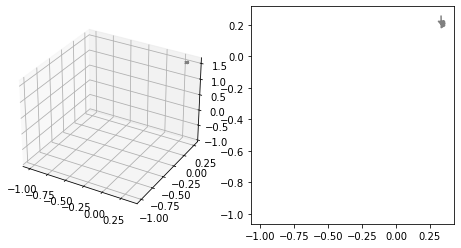

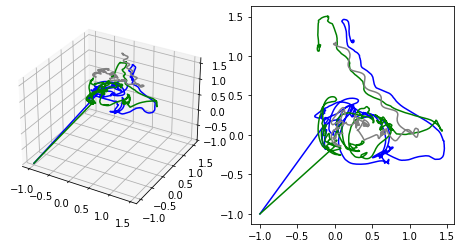

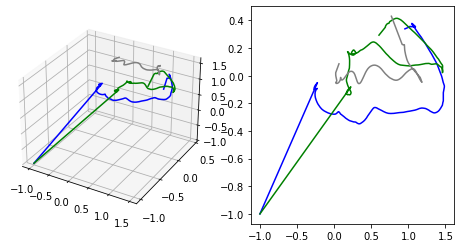

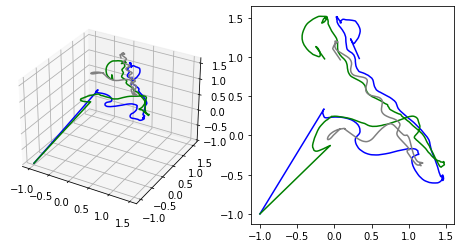

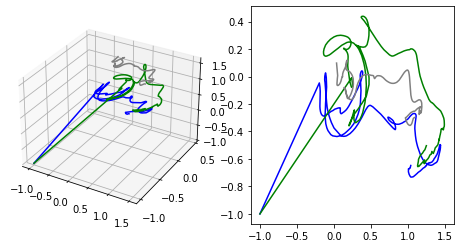

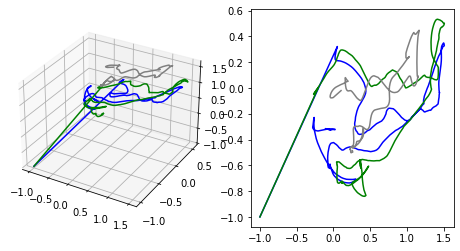

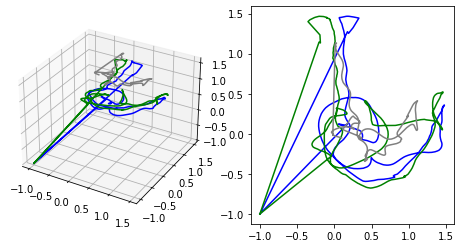

In [13]:
for i in range(7):

    idx = np.where(log.Trial == i)
    trial = log.iloc[idx]
    
    fig = plt.figure(figsize=plt.figaspect(1/2.))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot3D(s2f(trial.Lefthand_x[5:]), s2f(trial.Lefthand_z[5:]), s2f(trial.Lefthand_y[5:]), 'blue')
    ax.plot3D(s2f(trial.Righthand_x[5:]), s2f(trial.Righthand_z[5:]), s2f(trial.Righthand_y[5:]), 'green')
    ax.plot3D(s2f(trial.Viewpoint_x[5:]), s2f(trial.Viewpoint_z[5:]), s2f(trial.Viewpoint_y[5:]), 'gray')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(s2f(trial.Lefthand_x), s2f(trial.Lefthand_z), 'blue')
    ax.plot(s2f(trial.Righthand_x), s2f(trial.Righthand_z), 'green')
    ax.plot(s2f(trial.Viewpoint_x[5:]), s2f(trial.Viewpoint_z[5:]), 'gray')
